In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
# from torch.nn.functional import relu
# from torch.nn.functional import tanh
# from torch.nn.functional import sigmoid
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d

## Reduce the data size by shrinking the image and allow symbolic dynamics to occur (based on doppler-effect).

### Load the data

In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
)

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
}

### Symbolic dynamics through iteration and non-linearity.

In [117]:
relu = np.vectorize(lambda x: np.maximum(0, x))
sigmoid = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))
tanh = np.vectorize(np.tanh)

torch.Size([28, 28]) --> torch.Size([18, 18])


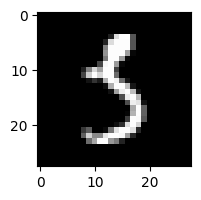

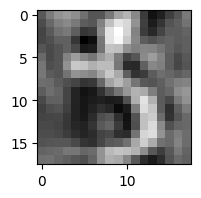

In [145]:
def apply_dynamics(tensor, f_act, velocities, v_o, v_m, kernel):
    working_sample = sample.numpy()

    for i, v_s in enumerate(velocities):
        # apply doppler effect to dct of sample
        s_dct = dct(dct(working_sample.T, norm='ortho').T, norm='ortho')
        s_dct = ((v_m + v_o) / (v_m + v_s)) * s_dct  # doppler-effect
        s_dct = f_act(s_dct)  # activation function
        working_sample = idct(idct(s_dct.T, norm='ortho').T, norm='ortho')
    # TODO: decrease sample size
        working_sample = convolve2d(working_sample, kernel, mode='valid')

    return torch.from_numpy(working_sample)

samples, labels = next(iter(loaders['train']))
sample = samples[0][0]

iters = 10
f_act = tanh  # relu, tanh, sigmoid
velocities = [-(i + 1) / (iters / 3) for i in range(iters)]  # negative if moving towards observer
# velocities = range(iters)
# velocities = np.full(iters, 1.5)
v_o = 0  # positive if moving towards source
v_m = 5.022
kernel = np.array([[0.25, 0.25],
                   [0.25, 0.25]])

result = apply_dynamics(sample, f_act, velocities, v_o, v_m, kernel)
print(f"{sample.shape} --> {result.shape}")

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap='gray')
plt.figure(2, figsize=(2, 2))
plt.imshow(result, cmap='gray')